In [0]:
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
from skimage.transform import resize

In [0]:
# DownloadDataset
import urllib.request
url = 'http://farsiocr.ir/Archive/DigitDB.zip'
urllib.request.urlretrieve(url, './Data.zip')

('./Data.zip', <http.client.HTTPMessage at 0x7f7dfd6200b8>)

In [0]:
from zipfile import ZipFile
address = './Data.zip'
d = ZipFile(address, 'r')
d.extractall()

In [0]:
# https://github.com/amir-saniyan/HodaDatasetReader
import struct
import numpy as np
import cv2


def __convert_to_one_hot(vector, num_classes):
    result = np.zeros(shape=[len(vector), num_classes])
    result[np.arange(len(vector)), vector] = 1
    return result


def __resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset+img_height, x_offset:x_offset+img_width] = img

    return dst_image


def read_hoda_cdb(file_name):
    with open(file_name, 'rb') as binary_file:

        data = binary_file.read()

        offset = 0

        # read private header

        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        H = struct.unpack_from('B', data, offset)[0]
        offset += 1

        W = struct.unpack_from('B', data, offset)[0]
        offset += 1

        TotalRec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        LetterCount = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        imgType = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        Comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        Reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (W > 0) and (H > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in range(TotalRec):

            StartByte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                W = struct.unpack_from('B', data, offset)[0]
                offset += 1

                H = struct.unpack_from('B', data, offset)[0]
                offset += 1

            ByteCount = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[H, W], dtype=np.uint8)

            if imgType == 0:
                # Binary
                for y in range(H):
                    bWhite = True
                    counter = 0
                    while counter < W:
                        WBcount = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        # x = 0
                        # while x < WBcount:
                        #     if bWhite:
                        #         image[y, x + counter] = 0  # Background
                        #     else:
                        #         image[y, x + counter] = 255  # ForeGround
                        #     x += 1
                        if bWhite:
                            image[y, counter:counter + WBcount] = 0  # Background
                        else:
                            image[y, counter:counter + WBcount] = 255  # ForeGround
                        bWhite = not bWhite  # black white black white ...
                        counter += WBcount
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(W * H), data, offset)
                offset += W * H
                image = np.asarray(data, dtype=np.uint8).reshape([W, H]).T

            images.append(image)
            labels.append(label)

        return images, labels


def read_hoda_dataset(dataset_path, images_height=32, images_width=32, one_hot=False, reshape=True):
    images, labels = read_hoda_cdb(dataset_path)
    assert len(images) == len(labels)

    X = np.zeros(shape=[len(images), images_height, images_width], dtype=np.float32)
    Y = np.zeros(shape=[len(labels)], dtype=np.int)

    for i in range(len(images)):
        image = images[i]
        # Image resizing.
        image = __resize_image(src_image=image, dst_image_height=images_height, dst_image_width=images_width)
        # Image normalization.
        image = image / 255
        # Image binarization.
        image = np.where(image >= 0.5, 1, 0)
        # Image.
        X[i] = image
        # Label.
        Y[i] = labels[i]

    if one_hot:
        Y = __convert_to_one_hot(Y, 10).astype(dtype=np.float32)
    else:
        Y = Y.astype(dtype=np.float32)

    if reshape:
        X = X.reshape(-1, images_height * images_width)
    else:
        X = X.reshape(-1, images_height, images_width, 1)

    return X, Y

In [0]:
train_images, train_labels = read_hoda_cdb('./Train 60000.cdb')

In [0]:
X_train_original = np.squeeze(train_images[:1000])
y_train = np.squeeze(train_labels[:1000])
X_test_original = np.squeeze(train_images[1000:1200])
y_test = np.squeeze(train_labels[1000:1200])

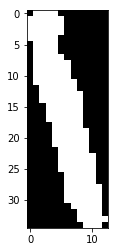

In [0]:
plt.imshow(X_train_original[999], cmap = 'gray')

In [0]:
X_train_original[0].shape

(27, 20)

Label for 70th image is: 8


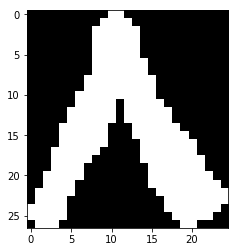

In [0]:
def show_image(i = 70, data = X_train_original, label = y_train):
  assert i <= len(data)
  image = data[i]
  lab = label[i]
  plt.imshow(image, cmap = 'gray')
  print(f"Label for {i}th image is: {lab}")

show_image()

In [0]:
# Resizing
X_train_5b5 = [resize(img, (25, 20)) for img in X_train_original]
X_test_5b5 = [resize(img, (25, 20)) for img in X_test_original]

In [0]:
# Reshaping
X_train = [x.reshape(-1) for x in X_train_5b5]
X_test = [x.reshape(-1) for x in X_test_5b5]

In [0]:
print(X_train[0].shape, X_test[0].shape)

(500,) (500,)


# Training Phase

https://www.kaggle.com/sdelecourt/cnn-with-pytorch-for-mnist

In [0]:
!pip3 install torch -U

     |████████████████████████████████| 748.9MB 27kB/s 
  Found existing installation: torch 1.1.0
    Uninstalling torch-1.1.0:
      Successfully uninstalled torch-1.1.0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable
import torch.optim as opt

In [0]:
np.random.seed(123) # for reproducibility

In [0]:
# list to np arrays
X_train = np.array(X_train_5b5)
y_train = np.array(y_train)
X_test = np.array(X_test_5b5)
y_test = np.array(y_test)

In [0]:
X_train[1]

array([[0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.0425, 0.5275, 1.    , 0.4825, 0.0375, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.2975, 0.8425, 1.    , 0.8275, 0.2625, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.1875,
        0.7125, 1.    , 1.    , 1.    , 0.6875, 0.1625, 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.375 ,
        1.    , 1.    , 1.    , 1.    , 1.    , 0.5275, 0.0825, 0.    ,
        0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.0275, 0.1   , 0.4375,
        1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.275 , 0.    ,
        0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.2475, 0.9   , 0.9375,
   

In [0]:
# Normalize inputs
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# X_train /= 255.
# X_test /= 255.

In [0]:
BATCH_SIZE = 10

torch_X_train = torch.from_numpy(X_train).type(torch.LongTensor)
torch_y_train = torch.from_numpy(y_train).type(torch.LongTensor)
# torch_y_train = F.one_hot(torch_y_train, 10)

torch_X_test = torch.from_numpy(X_test).type(torch.LongTensor)
torch_y_test = torch.from_numpy(y_test).type(torch.LongTensor)
# torch_y_test = F.one_hot(torch_y_test, 10)

# torch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train.reshape(-1, 500), torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test.view(-1, 500), torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

(<matplotlib.image.AxesImage at 0x7f7da186d160>, tensor(5))

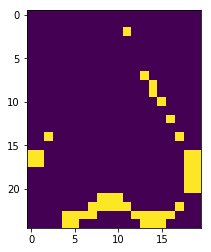

In [0]:
plt.imshow(torch_X_test[199]), torch_y_test[199]

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(500, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 10)
    
    def forward(self, x):
        X = F.relu(self.linear1(x))
        X = F.relu(self.linear2(X))
        # Find the error!
        # return F.softmax(self.linear, dim = 1)


        return F.softmax(self.linear3(X), dim = 0)
        
        
        # return F.softmax(self.linear3(X), dim = 1)

 
mlp = MLP()
print(mlp)

MLP(
  (linear1): Linear(in_features=500, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)


In [0]:
def fit(model, train_loader):
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
    error = nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss
    EPOCHS = 25
    model.train()
    for epoch in range(EPOCHS):
        correct = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
          var_X_batch = Variable(X_batch).float() # Switch it to long(), What happens?
          var_y_batch = Variable(y_batch).long()
          optimizer.zero_grad()
          output = model(var_X_batch)
          loss = error(output, var_y_batch)
          loss.backward()
          optimizer.step()

          # Total correct predictions
          predicted = torch.max(output.data, 1)[1] 
          correct += (predicted == var_y_batch).sum()
        # print(predicted)
          if batch_idx % 50 == 0:
              print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(
                  epoch, batch_idx*len(X_batch), len(train_loader.dataset), 100.*batch_idx / len(train_loader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))


In [0]:
fit(mlp, train_loader)

Epoch : 0 [0/1000 (0%)]	Loss: 2.302682	 Accuracy:0.000%
Epoch : 0 [500/1000 (50%)]	Loss: 2.301157	 Accuracy:12.745%
Epoch : 1 [0/1000 (0%)]	Loss: 2.299767	 Accuracy:10.000%
Epoch : 1 [500/1000 (50%)]	Loss: 2.290315	 Accuracy:40.392%
Epoch : 2 [0/1000 (0%)]	Loss: 2.287726	 Accuracy:30.000%
Epoch : 2 [500/1000 (50%)]	Loss: 2.245332	 Accuracy:43.922%
Epoch : 3 [0/1000 (0%)]	Loss: 2.209873	 Accuracy:40.000%
Epoch : 3 [500/1000 (50%)]	Loss: 2.181643	 Accuracy:43.529%
Epoch : 4 [0/1000 (0%)]	Loss: 2.181277	 Accuracy:60.000%
Epoch : 4 [500/1000 (50%)]	Loss: 2.161744	 Accuracy:48.824%
Epoch : 5 [0/1000 (0%)]	Loss: 2.047658	 Accuracy:80.000%
Epoch : 5 [500/1000 (50%)]	Loss: 2.055091	 Accuracy:50.784%
Epoch : 6 [0/1000 (0%)]	Loss: 2.071779	 Accuracy:40.000%
Epoch : 6 [500/1000 (50%)]	Loss: 2.069267	 Accuracy:47.255%
Epoch : 7 [0/1000 (0%)]	Loss: 1.934430	 Accuracy:70.000%
Epoch : 7 [500/1000 (50%)]	Loss: 1.979069	 Accuracy:56.471%
Epoch : 8 [0/1000 (0%)]	Loss: 2.113691	 Accuracy:50.000%
Epoch : 

tensor(8)


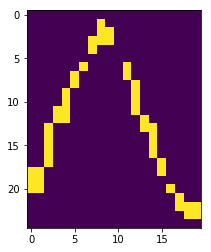

In [0]:
for a, b in enumerate(test_loader):
  # print(a[1])
  # xx_test = a[1]
  # xy_test = b[1]
  # plt.imshow(a[1].view(25, 20))
  # print(b)

  print(b[1][0])
  d = b[0].view(10, 25, 20)[0]
  plt.imshow(d)



  o = mlp(b[0].type(torch.FloatTensor))
  break

In [0]:
torch.max(o, dim = 0)

torch.return_types.max(values=tensor([0.9327, 0.8091, 0.9638, 0.8680, 0.4304, 0.9993, 0.9542, 0.9834, 0.9365,
        0.9205], grad_fn=<MaxBackward0>), indices=tensor([9, 3, 4, 8, 1, 6, 2, 9, 0, 3]))

In [0]:
def evaluate(model = mlp):
#model = mlp
    correct = 0 
    for test_imgs, test_labels in test_loader:
        #print(test_imgs.shape)
        test_imgs = Variable(test_imgs).float()
        output = model(test_imgs)
        predicted = torch.max(output,1)[1]
        correct += (predicted == test_labels).sum()
    print("Test accuracy:{:.1f}% ".format( float(correct) * 100 / (len(test_loader)*BATCH_SIZE)))
evaluate(mlp)

Test accuracy:61.0% 


# CNN

In [0]:
torch_X_train_cnn = torch_X_train.view(-1, 1,25,20).float()
torch_X_test_cnn = torch_X_test.view(-1,1,25,20).float()
print(torch_X_train_cnn.shape)
print(torch_X_test_cnn.shape)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train_cnn,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test_cnn,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = True)

torch.Size([1000, 1, 25, 20])
torch.Size([200, 1, 25, 20])


In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # self.conv1 = nn.Conv2d(1, 32, kernel_size = 3)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32,64, kernel_size=3)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        # x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1,768 )
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, dim = 0)
 
cnn = CNN()
print(cnn)

it = iter(train_loader)
X_batch, y_batch = next(it)
print(cnn.forward(X_batch))
X_batch, _ = next(it)
print(cnn.forward(X_batch))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
tensor([[0.1002, 0.1005, 0.1003, 0.0996, 0.0991, 0.0999, 0.0990, 0.1004, 0.1008,
         0.1005],
        [0.0993, 0.0997, 0.0991, 0.1003, 0.1003, 0.0996, 0.1007, 0.0996, 0.1001,
         0.0993],
        [0.1005, 0.1009, 0.1000, 0.0989, 0.1004, 0.0987, 0.0994, 0.1007, 0.0986,
         0.1006],
        [0.0990, 0.1008, 0.0988, 0.1015, 0.1020, 0.1004, 0.1023, 0.0990, 0.0987,
         0.0971],
        [0.0998, 0.0994, 0.0998, 0.1006, 0.0998, 0.0998, 0.1007, 0.1002, 0.0996,
         0.0995],
        [0.1000, 0.1007, 0.1009, 0.0999, 0.0992, 0.1004, 0.0990, 0.1010, 0.1010,
         0.0999],
        [0.0990, 0.1008, 0.0988, 0.1015, 0.1020, 0.1004, 0.1023, 0.0990, 0.0987,
         0.09

Epoch : 0 [0/1000 (0%)]	Loss: 2.302886	 Accuracy:0.000%
Epoch : 0 [500/1000 (50%)]	Loss: 2.302001	 Accuracy:10.392%
Epoch : 1 [0/1000 (0%)]	Loss: 2.301719	 Accuracy:10.000%
Epoch : 1 [500/1000 (50%)]	Loss: 2.302009	 Accuracy:20.392%
Epoch : 2 [0/1000 (0%)]	Loss: 2.301477	 Accuracy:10.000%
Epoch : 2 [500/1000 (50%)]	Loss: 2.301170	 Accuracy:25.098%
Epoch : 3 [0/1000 (0%)]	Loss: 2.299306	 Accuracy:30.000%
Epoch : 3 [500/1000 (50%)]	Loss: 2.297020	 Accuracy:34.314%
Epoch : 4 [0/1000 (0%)]	Loss: 2.292511	 Accuracy:40.000%
Epoch : 4 [500/1000 (50%)]	Loss: 2.294217	 Accuracy:32.941%
Epoch : 5 [0/1000 (0%)]	Loss: 2.267496	 Accuracy:50.000%
Epoch : 5 [500/1000 (50%)]	Loss: 2.207666	 Accuracy:38.824%
Epoch : 6 [0/1000 (0%)]	Loss: 2.172174	 Accuracy:50.000%
Epoch : 6 [500/1000 (50%)]	Loss: 2.037337	 Accuracy:43.725%
Epoch : 7 [0/1000 (0%)]	Loss: 2.154230	 Accuracy:30.000%
Epoch : 7 [500/1000 (50%)]	Loss: 1.921123	 Accuracy:50.588%
Epoch : 8 [0/1000 (0%)]	Loss: 1.951385	 Accuracy:60.000%
Epoch : 

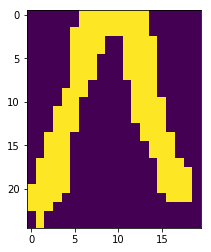

In [0]:
fit(cnn,train_loader)

In [0]:
out = cnn(*size_input*)
# Whats' the input size?

In [0]:
torch.max(out)

# Reference

* https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607